# Curve Fitting and $\chi^2$

Here we will study various uses of the $\chi^2$ including the use of `scipy.optimize.curve_fit()` to perform curve fitting and parameter estimation.

## Initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.special as sf
#Globally fix plot styling
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)

rng = np.random.default_rng()

## Definitions

Recall from lecture that we defined the $\chi^2$ as a measure of the distance between a set of data values, $y_i$ evaluated at points $x_i$ with uncertainties $\sigma_i$ to a model defined in terms a set of parameters $\vec p$ and represented as $f(x,\vec p)$ via
$$ \chi^2 = \sum_{i=1}^n \left( \frac{y_i - f(x_i,\vec p)}{\sigma_i} \right)^2. $$

The value of the $\chi^2$ tells us how close the model is to the data.  As a rule of thumb we expect $\chi^2\approx\nu$ where $\nu$ is the number of degrees of freedom.  To quantify this we define the goodness of fit, $Q$, as the probability that the $\chi^2$ would be larger than the value we calculate for the number of degrees of freedom we have.  (More precisely this is a one sided $p$-value.)  This can be calculated in terms of the normalized complement incomplete gamma function,
$$ Q\!\left( \frac\nu2, \frac{\chi^2}2 \right) = 1 - \frac{\gamma(\nu/2,\chi^2/2)}{\Gamma(\nu/2)}. $$
This can easily be calculated using `scipy.special.gammaincc()`.

### `scipy.stats`

SciPy includes a large module containing a powerful set of tools for performing statistical analyses.  We will **not** use that module here; it requires more knowledge of statistical techniques than needed for our uses here.  If you choose to use functions from this module make sure you understand what they do!

### Curve Fitting

In `scipy.optimize` there are many, many functions for all forms of minimization and optimization.  When we look through the list of functions two stand out, `least_squares` and `curve_fit`.  (There is also the "legacy function", `leastsq`, but this should not be used in new code and we will not discuss it.) We should look at these in more detail.

In [2]:
opt?

In [3]:
opt.least_squares?

In [1]:
opt.curve_fit?

Object `opt.curve_fit` not found.


It may come as a surprise that `least_squares` is more general routine than `curve_fit`!  In fact, for `least_squares` we need to define a function, the square of which will be minimized.  This function *need not be the $\chi^2$*.  On the other hand `curve_fit` does minimize the $\chi^2$, and will thus be the function we use.

Finally, as noted above the goodness of fit can be calculated using `gammaincc`.

In [ ]:
sf.gammaincc?

## Fit Random Data

Consider the simple function
$$ f(x, a_1, a_2, a_3) = \sin^2(a_1 x) + a_2 \cos^2(a_3 x) $$
where the $a_j$ are parameters.  Here we generate random values for $x$ in interval $x\in(0,2)$ and random "data" by including Gaussian fluctuations with variance $\sigma_y$.  Since we are generating random values the results for the analysis below can/will change.  It is good to run through the analysis a few times with different random data to see how things change.

In [5]:
x = rng.random(size=20) * 2
a1 = 1.4
a2 = 6.0
a3 = 0.2
def ymodel(x, a1, a2, a3):
    return np.sin(a1*x)**2 + a2*np.cos(a3*x)**2
ytrue = ymodel(x, a1, a2, a3)
sigma_y = 0.2
y = ytrue + sigma_y * rng.normal(size=len(ytrue))

Next we plot the data and the true curve to see what it looks like.  To plot data points with error bars we use, not surprisingly, `errorbar`.  It has many options and gives us full control over the points and the error bars.  In particular it can handle asymmetric error bars on both the $x$ and $y$ axes.  For simple plots, such as the one here, its use is straightforward.,aspline(time)

In [ ]:
plt.errorbar?

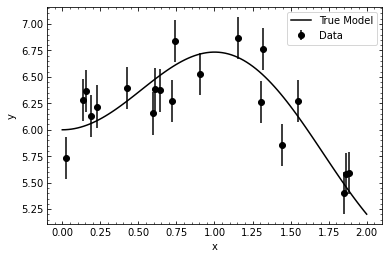

In [6]:
# A quick plot ....
xfine = np.linspace(0, 2, 100)
plt.errorbar(x, y, yerr=sigma_y, fmt='ko', label='Data')
plt.plot(xfine, ymodel(xfine, a1, a2, a3), 'k-', label='True Model')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(numpoints=1, loc='best');

The curve in the line above is the true curve.  This may **not** be the best fit!  We can use the $\chi^2$ to quantify how close the data is to the true model.  You will explore this much more in the prelab.  See that for more details.

In [7]:
chisq = np.sum(((y - ymodel(x, a1, a2, a3)) / sigma_y)**2)
dof = len(y) # WHY?!
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(f"""True model :
chisq = {chisq}
dof = {dof}
goodness of fit = {Q}""")

True model :
chisq = 26.31343388035818
dof = 20
goodness of fit = 0.15570788547484501


Next we perform the fit using `scipy.optimize.curve_fit`.  Notice that we pass in the $x$, $y$, and uncertainties, $\sigma_y$.  Note that the uncertainties we pass in are **absolute uncertainties**.  Roughly this means that they are "scaled correctly".  This is pretty much what we always mean when we do an experiment (at least in physics), thus we need to set `absolute_sigma=True` since this is **not the default** (which surprises me).  Returned is a `tuple` containing the best fit parameters in the array `p` and the covariance matrix in `C`.  The square root of the diagonal elements of the covariance matrix are the fit uncertainties for the parameters.

We calculate the $\chi^2$ for the fit using the definition from above.  To do this we must pass the fitted parameters to the function that defines our model.  Our model has three parameters so `p` will be a three element array.  In principle we would need to call it as `ymodel(x, p[0], p[1], p[2])`.  Even for just three parameters that is tedious.  Further, if we change the number of parameters in the model we would need to change every place we call the model function with fitted parameters.  A much better approach is to just use `*p` as `ymodel(x, *p)`.  This expands the array exactly as we need for passing to a function and works for any number of parameters in `p`.

In [8]:
(p, C) = opt.curve_fit(ymodel, x, y, sigma=sigma_y,
                       absolute_sigma=True)

ValueError: `sigma` has incorrect shape.

Um, that failed! Why?  As the error says, there is a problem with the shape of `sigma` which we have stored in `sigma_y`.

In [9]:
sigma_y

0.2

Notice that `sigma_y` is just a single number, but if we go back and check the documentation ... we find it needs to be an array.  There are a couple of ways to fix this.  The easiest is probably to make `sigma_y` and array.  Notice that this will not change any of the other calculations we have (or will) do so there is nothing wrong with this.  Alternatively we could just make the appropriate change when we call `curve_fit()`.

In [10]:
# Since we will call curve_fit more than once, just redefine sigma_y
sigma_y = np.ones_like(y) * sigma_y
(p, C) = opt.curve_fit(ymodel, x, y, sigma=sigma_y,
                       absolute_sigma=True)
sigp = np.sqrt(np.diag(C))
chisq = np.sum(((y - ymodel(x, *p)) / sigma_y)**2)
dof = len(y) - len(p)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)

print(f"""Best fit:
a1 = {p[0]} +/- {sigp[0]}
a2 = {p[1]} +/- {sigp[1]}
a3 = {p[2]} +/- {sigp[2]}
chisq = {chisq}
dof = {dof}
goodness of fit = {Q}""")

Best fit:
a1 = -122.59663662121461 +/- 0.06725989859955113
a2 = 9.327893906971275 +/- 0.09097036961105495
a3 = -120.71624569371005 +/- 0.006155139033720767
chisq = 4624.856540298545
dof = 17
goodness of fit = 0.0


A few things happened here.  Notice we did not tell `curve_fit` anything about the model being fit, in particular we did not tell it the number of parameters.  Yet it was able to determine there were three!  Using the introspection capabilities in Python `curve_fit` can often determine how many parameters are passed to a function.  It used that information to provide best fit estimates for the three parameters in our model.  Except that it (probably?) did not do a very good job!  The parameters are (probably) not very close to the true values, the $\chi^2$ is very large, and the goodness of fit is horrible.  Let us look at this more carefully by plotting the data, the true model, and the best fit.

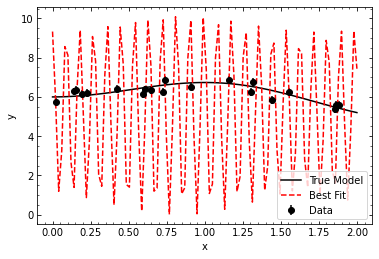

In [11]:
plt.errorbar(x, y, yerr=sigma_y, fmt='ko', label='Data')
plt.plot(xfine, ymodel(xfine, a1, a2, a3), 'k-', label='True Model')
plt.plot(xfine, ymodel(xfine, *p), 'r--', label='Best Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(numpoints=1, loc='lower right')
plt.minorticks_on()

This should not look like a very good fit at all!  What happened?  Here we are performing a **non-linear fit**.  Unlike linear fits, non-linear ones are sensitive to the initial guesses for the parameters.  Since we did not provide initial guesses, defaults were chosen and the defaults were not very good for our model.  The general problem is that finding the **global minimum** in a high dimensional space is very difficult.  It is easy to get stuck in a local minimum and hard to know if there is a deeper minimum somewhere else or what direction to go to search for it.  Minimization in more than one dimension thus requires a guess for where to start looking and the quality of the minimum found will depend on the quality of the initial guess.

For `curve_fit` we can provide initial guesses using the `p0` keyword.  This is an array with a guess for each of the parameters.  For a non-linear fit we should always provide initial guesses.  How we determine what a good guess is will be problem dependent; there is no general rule.  Here we know the true values so use them as a guess.

Best fit:
a1 = 1.2026617391185048 +/- 0.10202660557533479
a2 = 6.102352737870207 +/- 0.08845227210229
a3 = 0.2478624287866562 +/- 0.024939762817654205
chisq = 23.958293690835557
dof = 17
goodness of fit = 0.12057259876838543


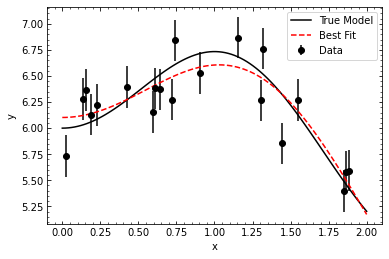

In [12]:
(p, C) = opt.curve_fit(ymodel, x, y, sigma=sigma_y,
                       p0=np.array([a1, a2, a3]),
                       absolute_sigma=True)
sigp = np.sqrt(np.diag(C))
chisq = np.sum(((y - ymodel(x, *p)) / sigma_y)**2)
dof = len(y) - len(p)
Q = sf.gammaincc(0.5*dof, 0.5*chisq)
print(f"""Best fit:
a1 = {p[0]} +/- {sigp[0]}
a2 = {p[1]} +/- {sigp[1]}
a3 = {p[2]} +/- {sigp[2]}
chisq = {chisq}
dof = {dof}
goodness of fit = {Q}""")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(x, y, yerr=sigma_y, fmt='ko', label='Data')
ax.plot(xfine, ymodel(xfine, a1, a2, a3), 'k-', label='True Model')
ax.plot(xfine, ymodel(xfine, *p), 'r--', label='Best Fit')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(numpoints=1, loc='best')
ax.minorticks_on()

This looks much better.  The parameters should now be in good agreement with the true values and the plot looks much better.  Both the $\chi^2$ and the goodness of fit should be consistent with what we mean by a "good fit".